<a href="https://colab.research.google.com/github/Champkavi27/cs50.readthedocs.io/blob/main/DR_EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle_API'

In [ ]:
!kaggle datasets download -d sachinkumar413/diabetic-retinopathy-dataset

 96% 337M/350M [00:02<00:00, 142MB/s]
100% 350M/350M [00:02<00:00, 150MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/diabetic-retinopathy-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Data/')


In [ ]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



print("All done")

All done


In [ ]:
#Convert files to lists
Path_data = '/content/Data'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/Data/Healthy')
Mild = os.listdir('/content/Data/Mild DR')
Moderate = os.listdir('/content/Data/Moderate DR')
Proliferate = os.listdir('/content/Data/Proliferate DR')
Severe = os.listdir('/content/Data/Severe DR')

NameError: name 'os' is not defined

In [ ]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Mild DR', 'Proliferate DR', 'Healthy', 'Severe DR', 'Moderate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [ ]:
#Create a Dataframe
# Get Paths

Path_data = '/content/Data'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

NameError: name 'os' is not defined

# 3 Data Preptocessing

## A- Random Over sampling

more preferred with text data not with images

In [ ]:
#X= Df.drop(['Labels'], axis = 1)
#y = Df['Labels']
#y.value_counts()

In [ ]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy= 'not majority')#string
#ros = RandomOverSampler(sampling_strategy= 1) #Numerical value

#x_ros, y_ros= ros.fit_resample(X, y)

#ax = y_ros.value_counts().plot.pie(autopct='%.2f')
#_ = ax.set_title('over-sampling')

## B- Split data into train, valid, test

In [ ]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

NameError: name 'train_test_split' is not defined

## C- Data Augmentation

In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

## D- Represent a sample

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

## A- Create a model using transfer learning with EfficientNetB3


In [ ]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate



43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [ ]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                        

## C- Training phase

In [ ]:
epochs = 50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 117s 495ms/step - loss: 1.7423 - acc: 0.4591 - val_loss: 1.4443 - val_acc: 0.5018
Epoch 2/50
110/110 [==============================] - 50s 449ms/step - loss: 1.1825 - acc: 0.5764 - val_loss: 1.2371 - val_acc: 0.5418
Epoch 3/50
110/110 [==============================] - 50s 451ms/step - loss: 1.0860 - acc: 0.5877 - val_loss: 1.0028 - val_acc: 0.6436
Epoch 4/50
110/110 [==============================] - 49s 446ms/step - loss: 0.9838 - acc: 0.6432 - val_loss: 0.9789 - val_acc: 0.6327
Epoch 5/50
110/110 [==============================] - 52s 470ms/step - loss: 0.9398 - acc: 0.6382 - val_loss: 0.9514 - val_acc: 0.6364
Epoch 6/50
110/110 [==============================] - 49s 448ms/step - loss: 0.8985 - acc: 0.6491 - val_loss: 0.9127 - val_acc: 0.6655
Epoch 7/50
110/110 [==============================] - 50s 451ms/step - loss: 0.8398 - acc: 0.6759 - val_loss: 0.9020 - val_acc: 0.7055
Epoch 8/50
110/110 [==============================] - 

## D- Evaluation

In [ ]:
model.save('/content/saved_model/efficientnetB3.h5 ')

In [ ]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## E- Let's Visualize it

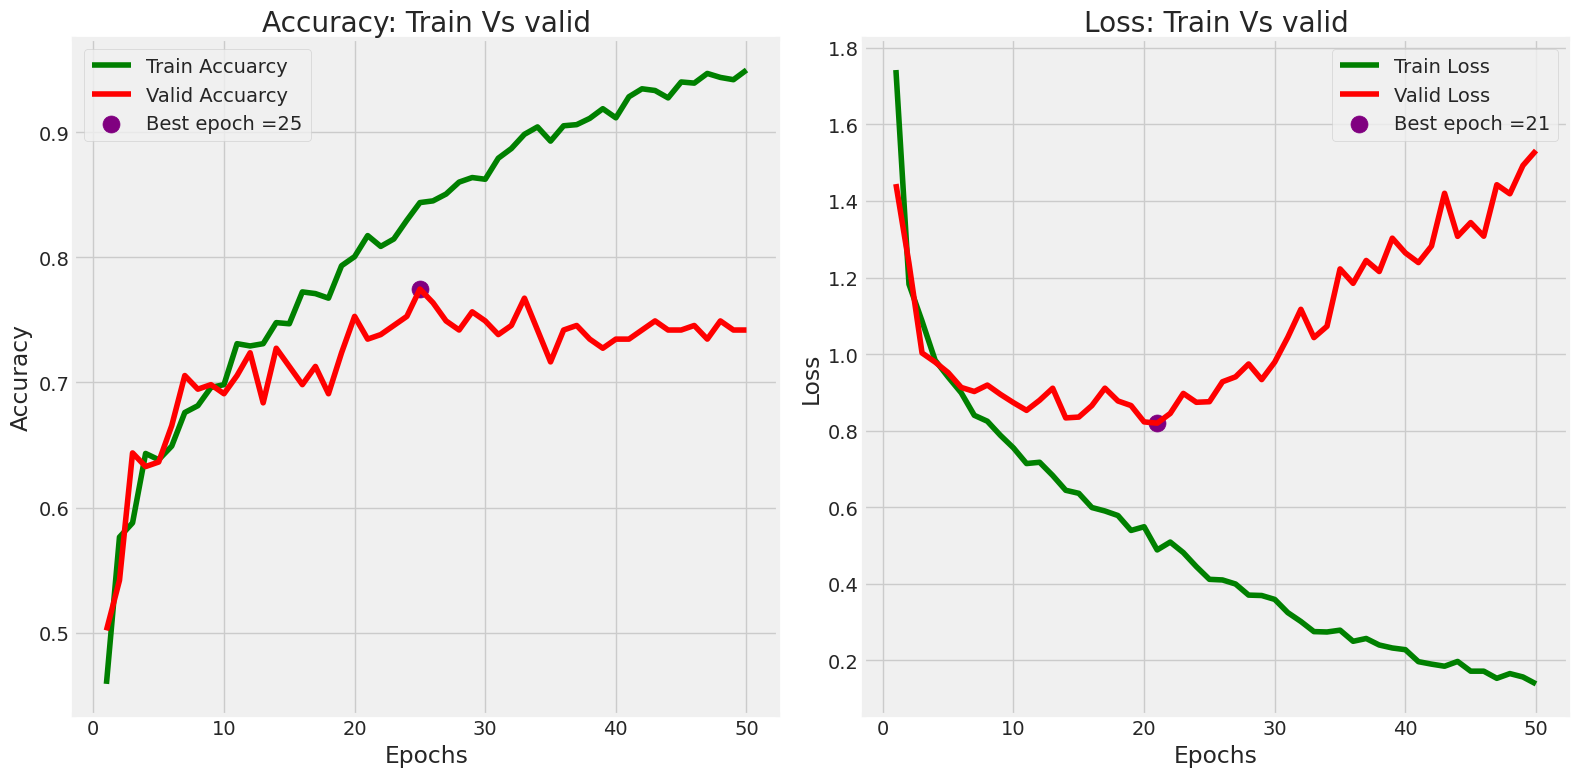

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 1s 78ms/step - loss: 1.1730 - acc: 0.7709
Train Scores : 
    accuracy: 0.9863636493682861 
      Loss:  0.03938926011323929 
________________________
Valid Scores : 
    accuracy: 0.7418181896209717 
      Loss:  1.5318220853805542 
________________________
Test Scores : 
    accuracy: 0.7709090709686279 
      Loss:  1.172987461090088 
________________________


# 5 Get  predictions

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Diabetic Retinopathy/effB3_CNN_DR.h5')

In [ ]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[9.5549549e-06 9.0194827e-01 1.2672264e-03 9.1669858e-02 5.1050745e-03]
 [7.3805122e-06 4.4363431e-05 9.9186605e-01 3.6863502e-04 7.7134483e-03]
 [9.9977475e-01 5.1188210e-05 1.7410358e-04 8.7014307e-09 1.2297390e-08]
 ...
 [3.6047993e-03 9.7460784e-03 7.8744173e-01 1.2631775e-01 7.2889581e-02]
 [1.0000000e+00 3.7619490e-09 7.9747681e-11 2.5622907e-17 7.5931057e-15]
 [2.2831222e-03 1.1166300e-01 8.6125118e-01 1.3208558e-02 1.1594149e-02]]
[1 2 0 2 2 0 2 2 0 0 4 3 2 0 2 2 0 2 3 2 0 2 1 2 4 2 2 0 2 0 0 0 0 1 2 0 4
 4 1 0 0 2 2 0 2 2 2 4 0 0 2 2 0 1 2 0 0 0 0 0 0 2 0 2 0 0 2 0 2 2 3 2 0 1
 2 0 0 2 3 0 2 2 0 2 2 1 2 0 3 2 0 2 2 2 0 0 2 0 1 0 4 0 1 2 2 0 1 1 2 2 1
 0 2 2 0 0 0 1 0 2 1 2 2 2 2 2 2 0 1 2 0 2 0 0 2 0 0 0 0 0 2 0 2 0 0 1 0 0
 1 2 3 2 0 0 2 0 0 2 0 2 0 2 4 0 1 0 0 0 2 1 1 2 1 0 1 2 0 0 2 4 0 0 3 2 0
 3 0 0 2 2 2 0 0 1 1 1 3 2 1 2 0 2 0 0 0 1 2 0 2 3 0 2 0 2 2 0 2 0 2 3 0 0
 2 0 2 2 1 0 1 0 0 2 0 0 0 0 2 0 2 2 0 0 0 0 2 2 0 0 2 3 3 2 0 1 0 3 0 4 2
 1 3 2 2 2 2 2 2 2 0 1 1 3 2 0 

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[104,   0,   0,   0,   0],
       [  3,  19,  12,   2,   0],
       [  4,  10,  73,   2,   1],
       [  1,   3,  11,   9,   1],
       [  0,   1,   9,   3,   7]])

# Sensitivity, Specificity, AUC

In [ ]:
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

cm = confusion_matrix(Test.classes, y_pred)
true_positive = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_negative = cm[1][1]

# Sensitivity (True Positive Rate)
sensitivity = true_positive / (true_positive + false_negative)

# Specificity (True Negative Rate)
specificity = true_negative / (true_negative + false_positive)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.9719626168224299
Specificity: 1.0


In [ ]:
# prompt: please write code for auc score

from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(Test.classes, predictions,multi_class='ovr')
print("AUC Score:", auc_score)


AUC Score: 0.9144288401429895


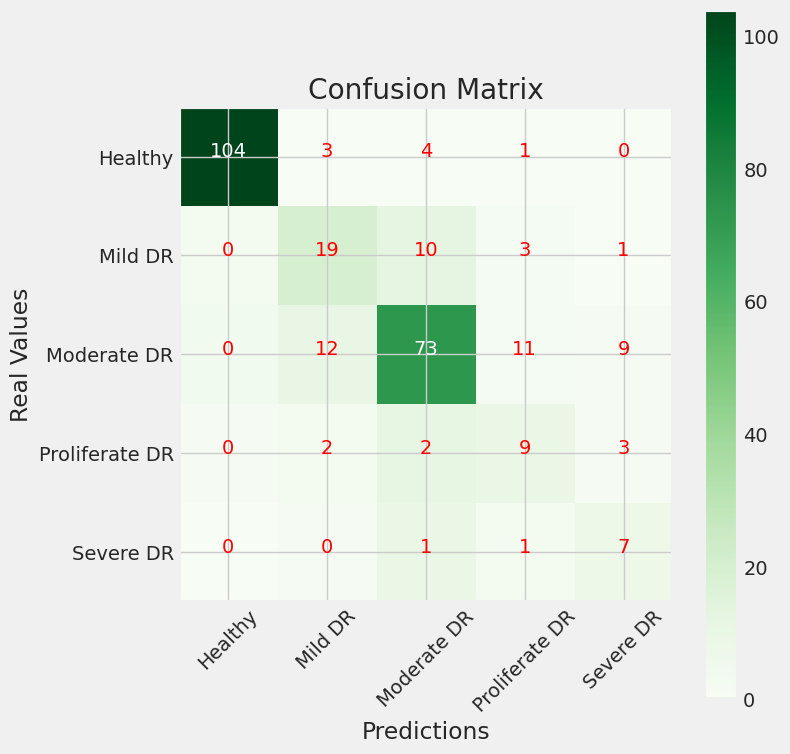

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


                precision    recall  f1-score   support

       Healthy       0.93      1.00      0.96       104
       Mild DR       0.58      0.53      0.55        36
   Moderate DR       0.70      0.81      0.75        90
Proliferate DR       0.56      0.36      0.44        25
     Severe DR       0.78      0.35      0.48        20

      accuracy                           0.77       275
     macro avg       0.71      0.61      0.64       275
  weighted avg       0.76      0.77      0.76       275

